In [76]:
#!pip install modin[ray]
#!pip install -U ipywidgets

In [1]:
import requests
from xml.etree import ElementTree as ET
import pandas as pd
#import modin.pandas as pd
import os
import datetime
import concurrent.futures

In [2]:
if not os.path.exists("raw_data"):
    os.makedirs("raw_data", exist_ok=True)

In [3]:
endpoint = 'https://storage.googleapis.com/validaciones_tmsa/'
def descargar_archivo(carpeta_destino, destino, url = endpoint):
    file = os.path.join(carpeta_destino, destino.split('/')[-1])
    print(f'Descargando {file}...')
    response_headers = requests.head(url+destino)
    print(f'Tamaño del archivo: {response_headers.headers["Content-Length"]} bytes')
    response = requests.get(url+destino)
    if response.status_code == 200:
        with open(file, 'wb') as f:
            f.write(response.content)
        print(f'Archivo descargado a {file}.')
    else:
        print(f'Error al descargar el archivo: {response.status_code}')

def descargar_archivos_paralelo(carpeta_destino, lista_destinos, url = endpoint):
    print(f'Descargando {len(lista_destinos)} archivos en paralelo...')
    with concurrent.futures.ThreadPoolExecutor() as executor:
        print(f'Usando {executor._max_workers} hilos...')
        executor.map(lambda x: descargar_archivo(carpeta_destino, x, url), lista_destinos)

In [4]:
def procesar_df_salidas(df):
    columns = ['Fecha_Transaccion', 'Tiempo', 'Dispositivo', 'Estacion']
    columns_upper = map(str.upper, columns)

    df = df[columns]
    df.columns = columns_upper

    df = df[df['ESTACION'].str.contains('U. NACIONAL', na=False)].drop('ESTACION', axis=1).convert_dtypes()
    df['DISPOSITIVO'] = df['DISPOSITIVO'].astype('int32')
    df['FECHA_TRANSACCION'] = pd.to_datetime(df['FECHA_TRANSACCION'], format='%Y-%m-%d').dt.date
    df['TIEMPO'] = pd.to_datetime(df['TIEMPO'], format='%H:%M:%S').dt.time
    df.sort_values(by=['FECHA_TRANSACCION', 'TIEMPO'], ascending=[True, True], inplace=True)
    df = df[df['TIEMPO'].between(pd.to_datetime('16:00:00').time(), pd.to_datetime('18:30:00').time())]
    df['TIEMPO'] = pd.to_datetime(df['TIEMPO'], format='%H:%M:%S')
    df['DIFERENCIA'] = df.groupby(['FECHA_TRANSACCION', 'DISPOSITIVO'])['TIEMPO'].diff().dt.total_seconds()
    df.dropna(subset=['DIFERENCIA'], inplace=True)
    df.sort_values(by=['FECHA_TRANSACCION', 'DISPOSITIVO', 'TIEMPO'], ascending=[True, True, True], inplace=True)
    df['TIEMPO'] = df['TIEMPO'].dt.time
    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
def procesar_df_ingresos(df):
    columns = ['Fecha_Transaccion', 'Dispositivo', 'Estacion_Parada']
    columns_upper = map(str.upper, columns)

    df = df[columns]
    df.columns = columns_upper

    df = df[df['ESTACION_PARADA'].str.contains('U. NACIONAL', na=False)].drop('ESTACION_PARADA', axis=1).convert_dtypes()
    df['DISPOSITIVO'] = df['DISPOSITIVO'].astype('int32')
    df['FECHA_TRANSACCION'] = pd.to_datetime(df['FECHA_TRANSACCION'], format='%Y-%m-%d %H:%M:%S')
    df['HORA'] = df['FECHA_TRANSACCION'].dt.time
    df['FECHA_TRANSACCION'] = df['FECHA_TRANSACCION'].dt.date
    df.sort_values(by=['FECHA_TRANSACCION', 'HORA'], ascending=[True, True], inplace=True)
    df = df[df['HORA'].between(pd.to_datetime('16:00:00').time(), pd.to_datetime('18:45:00').time())]
    df['HORA'] = pd.to_datetime(df['HORA'], format='%H:%M:%S')
    df['DIFERENCIA'] = df.groupby(['FECHA_TRANSACCION', 'DISPOSITIVO'])['HORA'].diff().dt.total_seconds()
    df.dropna(subset=['DIFERENCIA'], inplace=True)
    df.sort_values(by=['FECHA_TRANSACCION', 'DISPOSITIVO', 'HORA'], ascending=[True, True, True], inplace=True)
    df['HORA'] = df['HORA'].dt.time
    df.reset_index(drop=True, inplace=True)

    return df

In [6]:
def procesar_lista_dfs(carpeta, file, func):
    f_name = os.path.join(carpeta, file.split('/')[1])

    try:
        df_tmp = pd.read_csv(f_name)
        df_tmp = func(df_tmp)
        print(f'Data frame {f_name} procesado')
        try:
            #os.remove(f_name)
            print(f'Archivo {f_name} eliminado')
        except Exception as e:
            print(f'Error eliminando el archivo {f_name}: {e}')
            return None
    except Exception as e:
        print(f'Error procesando el df {f_name}: {e}')
        return None
    return df_tmp

In [7]:
response = requests.get(endpoint)
xml_data = response.text

root = ET.fromstring(xml_data)

# Ingresos

In [8]:
files_ingresos = []

namespace = {'ns': 'http://doc.s3.amazonaws.com/2006-03-01'}
total_size = 0
for element, size in zip(root.iterfind('.//ns:Key', namespace), root.iterfind('.//ns:Size', namespace)):
    if 'validacionTroncal2024' in element.text:
        files_ingresos.append(element.text)
        total_size += int(size.text)

In [9]:
total_size_gb = total_size / (1024**3)
print(f'Tamaño total: {total_size_gb:.2f} GB')

Tamaño total: 45.22 GB


In [10]:
len(files_ingresos)

86

In [11]:
files_ingresos_to_download = files_ingresos[-20:]
len(files_ingresos_to_download)

20

In [12]:
ingresos_ultimos_20d_2024= pd.DataFrame()

files_ingresos_to_download = files_ingresos[-20:]
length = len(files_ingresos_to_download)
batches = 4
for i in range(batches):
    print(f'Procesando batch {i+1}/{batches}...')
    files_ingresos_batch = files_ingresos_to_download[i*length//batches:(i+1)*length//batches]
    descargar_archivos_paralelo("raw_data", files_ingresos_batch)
    dataframes = [procesar_lista_dfs("raw_data", f, procesar_df_ingresos) for f in files_ingresos_batch]
    ingresos_ultimos_20d_2024 = pd.concat([ingresos_ultimos_20d_2024] + dataframes, join='outer', ignore_index=True)

print('**********TODOS LOS ARCHIVOS HAN SIDO PROCESADOS**********')

Procesando batch 1/4...
Descargando 5 archivos en paralelo...
Usando 12 hilos...
Descargando raw_data\validacionTroncal20240415.csv...
Descargando raw_data\validacionTroncal20240416.csv...
Descargando raw_data\validacionTroncal20240417.csv...
Descargando raw_data\validacionTroncal20240418.csv...
Descargando raw_data\validacionTroncal20240419.csv...
Tamaño del archivo: 664868782 bytes
Tamaño del archivo: 705764534 bytes
Tamaño del archivo: 682319797 bytes
Tamaño del archivo: 641647361 bytes
Tamaño del archivo: 699438055 bytes
Archivo descargado a raw_data\validacionTroncal20240417.csv.
Archivo descargado a raw_data\validacionTroncal20240419.csv.
Archivo descargado a raw_data\validacionTroncal20240416.csv.
Archivo descargado a raw_data\validacionTroncal20240415.csv.
Archivo descargado a raw_data\validacionTroncal20240418.csv.
Data frame raw_data\validacionTroncal20240415.csv procesado
Archivo raw_data\validacionTroncal20240415.csv eliminado
Data frame raw_data\validacionTroncal20240416.c

In [13]:
ingresos_ultimos_20d_2024.to_csv('ingresos_ultimos_20d_2024.csv')
#ingresos_ultimos_20d_2024 = pd.read_csv('ingresos_ultimos_20d_2024.csv')

In [14]:
ingresos_ultimos_20d_2024.describe()

,DISPOSITIVO,DIFERENCIA
count,3.779500e+04,37795.000000
mean,2.839048e+07,16.973727
std,1.069183e+08,82.623907
min,1.000054e+07,0.000000
25%,1.000055e+07,4.000000
50%,1.000055e+07,6.000000
75%,1.000055e+07,14.000000
max,6.500003e+08,8297.000000


In [15]:
ingresos_ultimos_20d_2024[ingresos_ultimos_20d_2024['DIFERENCIA'] == 3832].index

Index([13781], dtype='int64')

<Axes: >

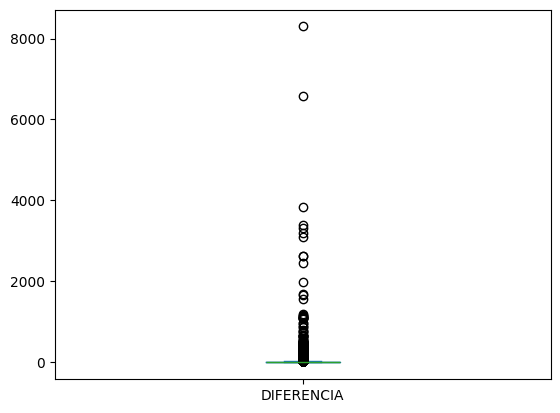

In [16]:
ingresos_ultimos_20d_2024['DIFERENCIA'].plot(kind='box')

In [17]:
Q1 = ingresos_ultimos_20d_2024['DIFERENCIA'].quantile(0.25)
Q3 = ingresos_ultimos_20d_2024['DIFERENCIA'].quantile(0.75)
IQR = Q3 - Q1

filtro = (ingresos_ultimos_20d_2024['DIFERENCIA'] >= Q1 - 1.5 * IQR) & (ingresos_ultimos_20d_2024['DIFERENCIA'] <= Q3 + 1.5 * IQR)
ingresos_ultimos_20d_2024_filtrado = ingresos_ultimos_20d_2024.loc[filtro]  

<Axes: >

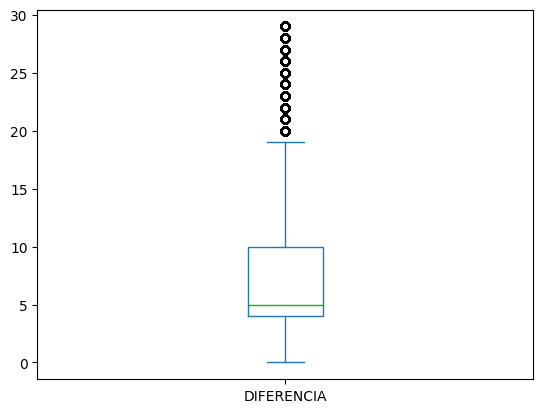

In [18]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].plot(kind='box')

<Axes: ylabel='Frequency'>

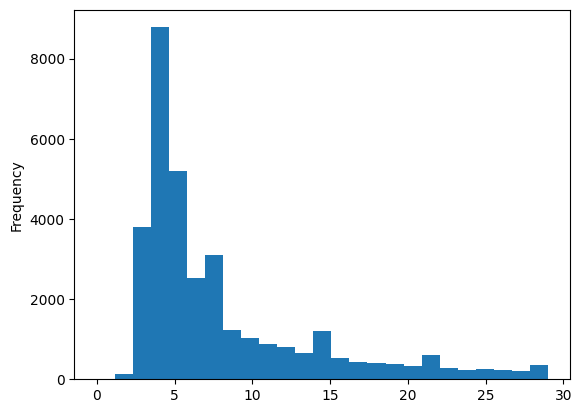

In [19]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].plot(kind='hist', bins=25)

<Axes: ylabel='Density'>

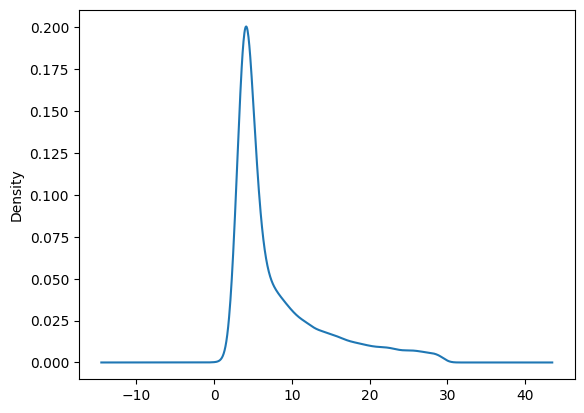

In [20]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].plot(kind='kde')

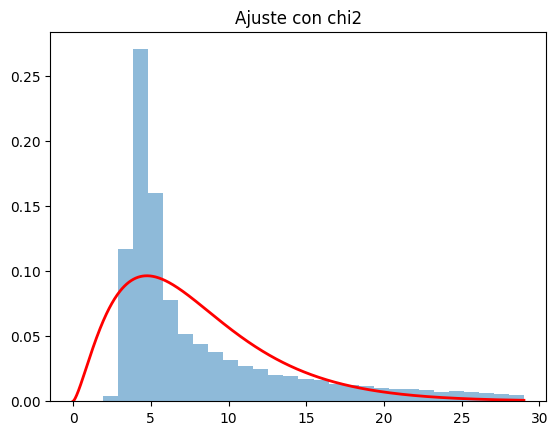

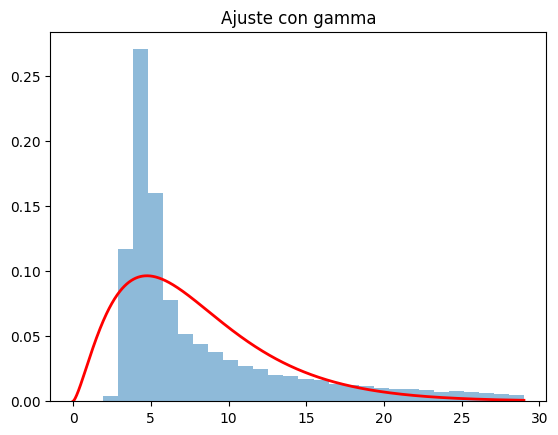

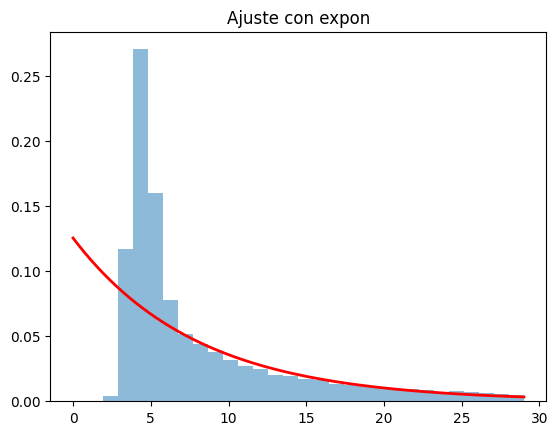

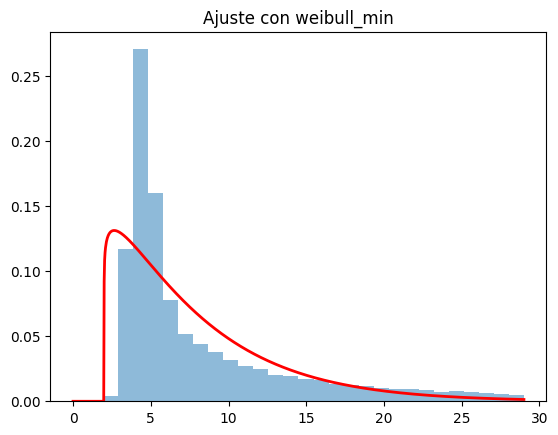

d:\Users\mateo\GitHub\ps\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6556: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


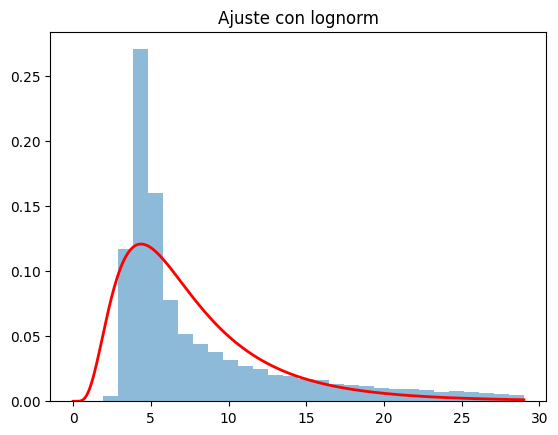

In [21]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

# Obtén los datos de la columna que te interesa
datos = ingresos_ultimos_20d_2024_filtrado['DIFERENCIA']

# Define las distribuciones a probar
distribuciones = [st.chi2, st.gamma, st.expon, st.weibull_min, st.lognorm]

# Para cada distribución
for distribucion in distribuciones:
    # Ajusta los datos a la distribución
    parametros = distribucion.fit(datos)
    
    # Crea una figura y un eje para el gráfico
    fig, ax = plt.subplots(1, 1)
    
    # Genera una serie de valores x
    x = np.linspace(min(datos), max(datos), 1000)
    
    # Genera los valores y de la PDF ajustada
    y = distribucion.pdf(x, *parametros)
    
    # Grafica los datos y la PDF ajustada
    ax.hist(datos, bins=30, density=True, alpha=0.5)
    ax.plot(x, y, 'r-', lw=2)
    
    # Muestra el gráfico
    plt.title(f'Ajuste con {distribucion.name}')
    plt.show()

In [22]:
ingresos_ultimos_20d_2024['DIFERENCIA'].describe()

count    37795.000000
mean        16.973727
std         82.623907
min          0.000000
25%          4.000000
50%          6.000000
75%         14.000000
max       8297.000000
Name: DIFERENCIA, dtype: float64

In [26]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].describe()

count    33615.000000
mean         7.976707
std          5.988438
min          0.000000
25%          4.000000
50%          5.000000
75%         10.000000
max         29.000000
Name: DIFERENCIA, dtype: float64

In [24]:
files_ingresos[-20]

'ValidacionTroncal/validacionTroncal20240415.csv'

In [25]:
files_ingresos[-1]

'ValidacionTroncal/validacionTroncal20240504.csv'

# Salidas

In [102]:
files_salidas = []

namespace = {'ns': 'http://doc.s3.amazonaws.com/2006-03-01'}
total_size = 0
for element, size in zip(root.iterfind('.//ns:Key', namespace), root.iterfind('.//ns:Size', namespace)):
    if 'salidas2024' in element.text:
        files_salidas.append(element.text)
        total_size += int(size.text)

In [103]:
files_salidas_to_download = files_salidas[-20:]

In [104]:
salidas_ultimos_20d_2024= pd.DataFrame()

files_salidas_to_download = files_salidas[-20:]
length = len(files_salidas_to_download)
batches = 4
for i in range(batches):
    print(f'Procesando batch {i+1}/{batches}...')
    files_salidas_batch = files_salidas_to_download[i*length//batches:(i+1)*length//batches]
    descargar_archivos_paralelo("raw_data", files_salidas_batch)
    dataframes = [procesar_lista_dfs("raw_data", f, procesar_df_salidas) for f in files_salidas_batch]
    salidas_ultimos_20d_2024 = pd.concat([salidas_ultimos_20d_2024] + dataframes, join='outer', ignore_index=True)

print('**********TODOS LOS ARCHIVOS HAN SIDO PROCESADOS**********')

Procesando batch 1/4...
Descargando 5 archivos en paralelo...
Usando 12 hilos...
Descargando raw_data\salidas20240415.csv...
Descargando raw_data\salidas20240416.csv...
Descargando raw_data\salidas20240417.csv...
Descargando raw_data\salidas20240418.csv...
Descargando raw_data\salidas20240419.csv...
Tamaño del archivo: 20695876 bytes
Tamaño del archivo: 20682546 bytes
Tamaño del archivo: 20692389 bytes
Tamaño del archivo: 20817852 bytes
Tamaño del archivo: 20650982 bytes
Archivo descargado a raw_data\salidas20240418.csv.
Archivo descargado a raw_data\salidas20240417.csv.
Archivo descargado a raw_data\salidas20240419.csv.
Archivo descargado a raw_data\salidas20240415.csv.
Archivo descargado a raw_data\salidas20240416.csv.
Data frame raw_data\salidas20240415.csv procesado
Archivo raw_data\salidas20240415.csv eliminado
Data frame raw_data\salidas20240416.csv procesado
Archivo raw_data\salidas20240416.csv eliminado
Data frame raw_data\salidas20240417.csv procesado
Archivo raw_data\salidas2

In [113]:
bins = pd.date_range(start='16:00:00', end='18:30:00', freq='15min').time
bins

array([datetime.time(16, 0), datetime.time(16, 15), datetime.time(16, 30),
       datetime.time(16, 45), datetime.time(17, 0), datetime.time(17, 15),
       datetime.time(17, 30), datetime.time(17, 45), datetime.time(18, 0),
       datetime.time(18, 15), datetime.time(18, 30)], dtype=object)

In [105]:
salidas_ultimos_20d_2024.to_csv('salidas_ultimos_20d_2024.csv')

In [109]:
salidas_ultimos_20d_2024.groupby(by='DISPOSITIVO').count()

,FECHA_TRANSACCION,TIEMPO,DIFERENCIA
DISPOSITIVO,,,
10000543,100,100,100
10000544,100,100,100
10000545,100,100,100
10000546,150,150,150
10000547,150,150,150
10000548,150,150,150
10001648,150,150,150


In [29]:
ingresos_ultimos_20d_2024.groupby(by='DISPOSITIVO').count()

,FECHA_TRANSACCION,HORA,DIFERENCIA
DISPOSITIVO,,,
10000543,1032,1032,1032
10000544,2199,2199,2199
10000546,11977,11977,11977
10000547,14481,14481,14481
10000548,21,21,21
10001648,6999,6999,6999
650000292,1086,1086,1086


In [30]:
ingresos_ultimos_20d_2024['RANGO'] = ingresos_ultimos_20d_2024['HORA'].apply(lambda x: datetime.time(x.hour, x.minute // 15 * 15))

In [31]:
print('PROMEDIO INGRESOS POR DISPOSITIVO')
ingresos_ultimos_20d_2024.groupby(by=['FECHA_TRANSACCION', 'DISPOSITIVO', 'RANGO'])['HORA'].count().groupby(level=['DISPOSITIVO', 'RANGO']).mean().unstack().T

PROMEDIO INGRESOS POR DISPOSITIVO


DISPOSITIVO,10000543,10000544,10000546,10000547,10000548,10001648,650000292
RANGO,,,,,,,
16:00:00,16.714286,27.000000,58.400000,70.125000,NaN,32.142857,85.5
16:15:00,17.500000,28.500000,66.571429,71.812500,1.000000,41.071429,85.0
16:30:00,12.000000,30.666667,67.071429,78.266667,1.000000,37.800000,115.0
16:45:00,15.666667,29.166667,71.285714,77.133333,1.000000,41.142857,47.5
17:00:00,19.000000,35.714286,83.666667,91.625000,2.000000,52.533333,70.5
17:15:00,18.857143,41.571429,96.800000,102.375000,1.666667,64.125000,85.0
17:30:00,8.000000,32.571429,82.466667,90.312500,NaN,46.750000,NaN
17:45:00,10.857143,25.857143,74.733333,86.875000,1.000000,36.250000,NaN
18:00:00,11.666667,29.428571,76.533333,82.500000,NaN,38.500000,58.0


In [134]:
salidas_ultimos_20d_2024['RANGO'] = salidas_ultimos_20d_2024['TIEMPO'].apply(lambda x: datetime.time(x.hour, x.minute // 15 * 15))

In [135]:
salidas_ultimos_20d_2024.groupby(by=['FECHA_TRANSACCION', 'DISPOSITIVO', 'RANGO'])['TIEMPO'].count().groupby(level=['DISPOSITIVO', 'RANGO']).mean().unstack().T

DISPOSITIVO,10000543,10000544,10000545,10000546,10000547,10000548,10001648
RANGO,,,,,,,
16:15:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
16:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
16:45:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17:15:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17:45:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
18:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
18:15:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
